# Mask + Image Manipulation
This notebook reads in images, creates the mask targets, and uses a custom generator to randomly rotate/flip the targets.

In [1]:
import glob
import cv2
import os
import glob
import numpy as np
import pandas as pd
%matplotlib inline 

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.integrate import simps
from scipy import signal
from PIL import Image
import make_density_map as mdm

In [2]:
def get_im_cv2(path, img_width, img_height):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height))#, cv2.INTER_LINEAR)
    return resized

def load_data(path, data_type, img_width, img_height):
    X, X_id, y = [], [], []
    minpix = 2                                  #minimum number of pixels for crater to count
    files = glob.glob('%s*.png'%path)
    print "number of %s files are: %d"%(data_type,len(files))
    for fl in files:
        flbase = os.path.basename(fl)
        img = get_im_cv2(fl,img_width,img_height)
        X.append(img)
        X_id.append(fl)
        
        csv = pd.read_csv('%s.csv'%fl.split('.png')[0])
        csv.drop( np.where(csv["Diameter (pix)"] < minpix)[0], inplace=True )
        y.append(mdm.make_mask(csv, img, binary=True))
    return  X, y, X_id

def read_and_normalize_data(path, img_width, img_height, data_flag):
    if data_flag == 0:
        data_type = 'train'
    elif data_flag == 1:
        data_type = 'test'
    data, target, id = load_data(path, data_type, img_width, img_height)
    data = np.array(data, dtype=np.uint8)       #convert to numpy
    target = np.array(target, dtype=np.uint8)
    data = data.astype('float32')               #convert to float
    data = data / 255                           #normalize
    print('%s shape:'%data_type, data.shape)
    return data, target, id

In [3]:
train_data, train_target, train_id = read_and_normalize_data('training_set/', 300, 300, 0)

number of train files are: 20
('train shape:', (20, 300, 300, 3))


In [10]:
def custom_image_generator(data, target, batch_size=2):
    np.random.seed(0)
    L, W = data[0].shape[0], data[0].shape[1]
    while True:
        for i in range(0, len(data), batch_size):
            d, t = data[i:i+batch_size].copy(), target[i:i+batch_size].copy() #most efficient for memory?
            
            #horizontal/vertical flips
            for j in np.where(np.random.randint(0,2,batch_size)==1)[0]:
                d[j], t[j] = np.fliplr(d[j]), np.fliplr(t[j])                 #left/right 
            for j in np.where(np.random.randint(0,2,batch_size)==1)[0]:
                d[j], t[j] = np.flipud(d[j]), np.flipud(t[j])                 #up/down
                
            #random up/down and left/right pixel shifts
            npix = 1
            h = np.random.randint(-npix,2,batch_size)                         #horizontal shift
            v = np.random.randint(-npix,2,batch_size)                         #vertical shift
            for j in range(batch_size):
                d[j] = np.pad(d[j], ((npix,npix),(npix,npix),(0,0)), mode='constant')[npix+h[j]:L+h[j]+npix,npix+v[j]:W+v[j]+npix,:] 
                t[j] = np.pad(t[j], (npix,), mode='constant')[npix+h[j]:L+h[j]+npix,npix+v[j]:W+v[j]+npix]
            yield (d, t)

In [11]:
#Manipulate the first n_images in the training set
n_images = 10
images = []
for batch in custom_image_generator(train_data,train_target,len(train_data)):
    images.append(batch)
    break 

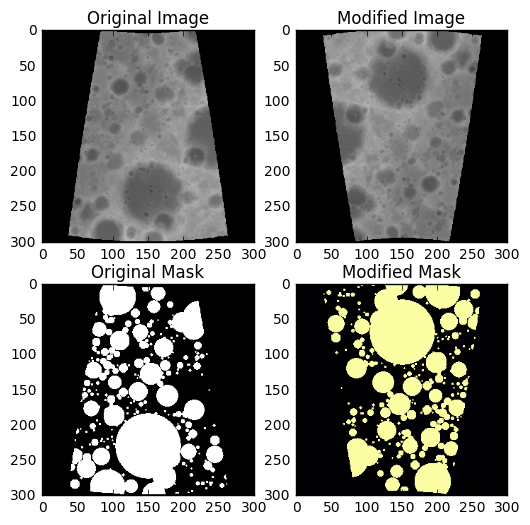

In [15]:
i=6      #i < n_images

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[6, 6])

ax1.imshow(train_data[i], origin='upper', cmap="Greys_r")
ax1.set_title('Original Image')

ax2.imshow(images[0][0][i], origin='upper', cmap="inferno")
ax2.set_title('Modified Image')

ax3.imshow(train_target[i], origin='upper', cmap="Greys_r")
ax3.set_title('Original Mask')

ax4.imshow(images[0][1][i], origin='upper', cmap="inferno")
ax4.set_title('Modified Mask')

#plt.savefig('sample.png')